This is Will's edit of a notebook originally written by Javier.

# Correlations between H II region parameters

We look at correlations between 6 principal measurements that fall into two groups: 

* Basic parameters: 
    * Size: $L$
    * Ionizing luminosity: $Q(\mathrm{H})$
    * Distance: $D$
* Velocity structure function parameters:
    * Velocity dispersion on plane of sky: $\sigma$
    * Velocity autocorrelation length scale: $\ell_0$
    * Structure function slope in inertial range: $m$

Colab's markdown renderer seems to have a bug that requires some math outside of a list in order to trigger latex parsing: $\alpha$. 

## Original table from Javier

In [1]:
import time
start_time=time.time()
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os
import lmfit
import statsmodels.api as sm

#import sys

In [2]:
Region =["NGC 604","NGC 595","Hubble X","Hubble V","30Dor","Carina","NGC 346","M8"   ,"OrionL","OrionS"]
LHa    =[4.46e39  ,2.29e39  ,3.98e38   ,7.41e38  ,5.74e39 ,3.98e39 ,4.67e38  ,2.95e37,1e37    ,1e37    ]
SFR    =[5.3e-3   ,2.6e-3   ,3.1e-4    ,1.5e-4   ,1.3e-2  ,1.0e-2  ,0.0021   ,1.0e-4 ,5.3e-5  ,5.3e-5  ]
n      =[3        ,4        ,5         ,8        ,250     ,500     ,100      ,60     ,150     ,4000    ] 
Diam   =[400      ,400      ,160       ,130      ,98.9    ,5       ,64       , 25    ,5       ,0.6     ]
R      =[200      ,200      ,80        ,65       ,49.4    ,7.5     ,32       ,12.5   ,2.5     ,0.3     ]
Dist   =[840      ,840      ,500       ,500      ,50      ,2.35    ,61.7     ,1.25   ,0.4     ,0.4     ]
m      =[1.95     ,1.75     ,1.7       ,1.62     , 1.22   ,1       ,1.13     ,1.36   ,0.9     ,1.44    ]
r0     =[8.75     ,8.99     ,3.62      ,2.7      ,2.69    ,0.55    ,1.4      ,1.78   ,0.84    ,0.062   ]
sig    =[7.39     ,6.64     ,2.8       ,3.59     ,15.8    ,4.22    ,5.6      ,2.7    ,3.23    ,3.1     ]
siglos =[16.21    ,18.33    ,12.3      ,13.4     ,31.7    ,22.46   ,1        ,13.6   ,6       ,6       ]
sigW   =[23.1     ,27.1     ,13.4      ,14.7     ,31.7    ,22.46   ,1        ,13.6   ,6       ,6       ]

Cambié la manera de especificar el dataframe porque tu método dejó las columnas con `dtype` de `object` en lugar de `float`, por ejemplo.  Entonces, no fue posible operar sobre las columnas después. 

In [3]:
data = pd.DataFrame(
    {
       "Region": Region,
       "LHa": LHa,
       "SFR": SFR,
       "n": n,
       "L [pc]": Diam,
       "R [pc]": R,
       "Dist [kpc]": Dist,
       "m": m,
       "r0 [pc]": r0,
       "sig [km/s]": sig,
       "siglos [km/s]": siglos,
    },
)

Checar que los tipos de las columnas sean adecuadas:

In [4]:
data.dtypes

Region            object
LHa              float64
SFR              float64
n                  int64
L [pc]           float64
R [pc]           float64
Dist [kpc]       float64
m                float64
r0 [pc]          float64
sig [km/s]       float64
siglos [km/s]    float64
dtype: object

In [5]:
data

,Region,LHa,SFR,n,L [pc],R [pc],Dist [kpc],m,r0 [pc],sig [km/s],siglos [km/s]
0,NGC 604,4.460000e+39,0.005300,3,400.0,200.0,840.00,1.95,8.750,7.39,16.21
1,NGC 595,2.290000e+39,0.002600,4,400.0,200.0,840.00,1.75,8.990,6.64,18.33
2,Hubble X,3.980000e+38,0.000310,5,160.0,80.0,500.00,1.70,3.620,2.80,12.30
3,Hubble V,7.410000e+38,0.000150,8,130.0,65.0,500.00,1.62,2.700,3.59,13.40
4,30Dor,5.740000e+39,0.013000,250,98.9,49.4,50.00,1.22,2.690,15.80,31.70
5,Carina,3.980000e+39,0.010000,500,5.0,7.5,2.35,1.00,0.550,4.22,22.46
6,NGC 346,4.670000e+38,0.002100,100,64.0,32.0,61.70,1.13,1.400,5.60,1.00
7,M8,2.950000e+37,0.000100,60,25.0,12.5,1.25,1.36,1.780,2.70,13.60
8,OrionL,1.000000e+37,0.000053,150,5.0,2.5,0.40,0.90,0.840,3.23,6.00
9,OrionS,1.000000e+37,0.000053,4000,0.6,0.3,0.40,1.44,0.062,3.10,6.00


## Change to log scale for most parameters

El analisis de la mayoría de las columnas sería mejor en escala logarítmica porque varían por varios ordenes de magnitud.  Entonces, hacemos una nueva versión de la tabla así. Dejamos la $m$ en escala lineal porque no varía mucho.

In [6]:
cols = data.columns
logdata = data.copy()
for col in cols:
    if col not in ["Region", "m"]:
        logdata[col] = np.round(np.log10(logdata[col]), 2)
        logdata.rename(columns={col: f"log {col}"}, inplace=True)
# Some minor changes to column names
logdata.rename(
    columns={
        "log LHa": "log L(H) [erg s^-1]",
        }, 
    inplace=True)
logdata

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.95,0.94,0.87,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.75,0.95,0.82,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.70,0.56,0.45,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.62,0.43,0.56,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,1.22,0.43,1.20,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.00,-0.26,0.63,1.35
6,NGC 346,38.67,-2.68,2.00,1.81,1.51,1.79,1.13,0.15,0.75,0.00
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,1.36,0.25,0.43,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.90,-0.08,0.51,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.44,-1.21,0.49,0.78


Make the label text bigger on the figures

In [7]:
sns.set_context("talk")

Repeat the pair plot of correlations between columns with the log-scale quantities. Use color to indicate the distance to the regions.

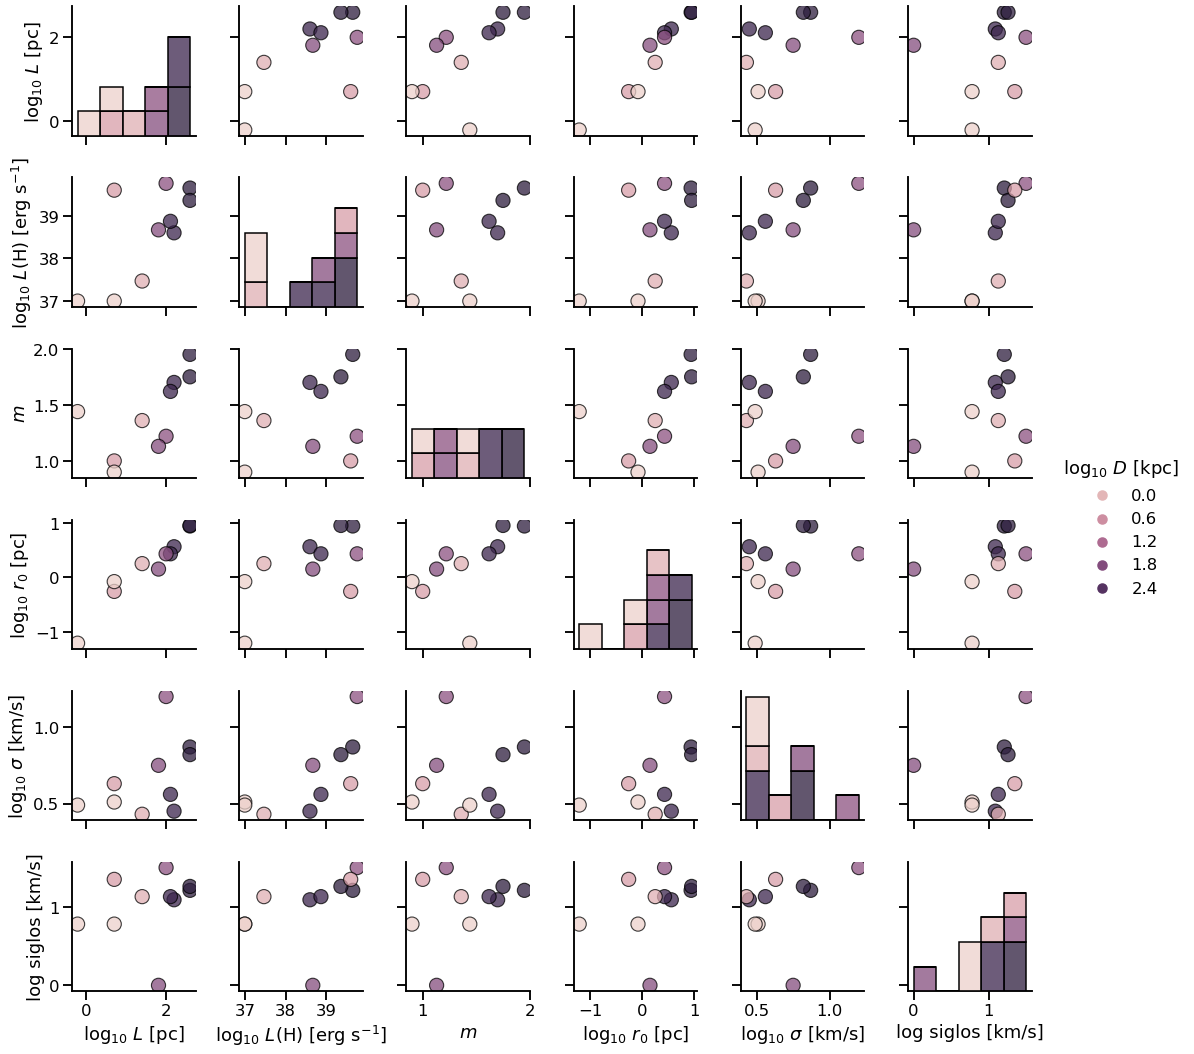

In [8]:
selected_vars = [ "log L [pc]","log L(H) [erg s^-1]", "log Dist [kpc]", "m", "log r0 [pc]", "log sig [km/s]", "log siglos [km/s]"]
plotdata = logdata[selected_vars].rename(
    columns={
        # Switch column names to use latex formatting to improve axis labels
        "log L [pc]": r"$\log_{10}\ L$ [pc]", 
        "log L(H) [erg s^-1]": r"$\log_{10}\ L(\mathrm{H})$ [erg s$^{-1}$]", 
        "m": "$m$", 
        "log r0 [pc]": r"$\log_{10}\ r_0$ [pc]", 
        "log sig [km/s]": r"$\log_{10}\ \sigma$ [km/s]", 
        "log Dist [kpc]": r"$\log_{10}\ D$ [kpc]",
    },
)

sns.pairplot(plotdata, 
             hue=r"$\log_{10}\ D$ [kpc]",
             plot_kws=dict(alpha=0.75, s=200, edgecolor="k"), 
             diag_kind='hist',
             diag_kws= dict(multiple='stack'),
             );

figname = "strucfunc-correlations"
# Save PDF and JPG versions of the figure
#plt.gcf().savefig(f"{figname}.pdf")
#plt.gcf().savefig(f"{figname}.jpg")

## Correlation coefficients

Calculate [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient), $r$, between each pair of variables:

In [9]:
logdata[selected_vars].corr()

,log L [pc],log L(H) [erg s^-1],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
log L [pc],1.000000,0.674686,0.923364,0.623182,0.964623,0.466705,0.236547
log L(H) [erg s^-1],0.674686,1.000000,0.714755,0.313537,0.625596,0.718054,0.453920
log Dist [kpc],0.923364,0.714755,1.000000,0.730472,0.820193,0.414552,0.190756
m,0.623182,0.313537,0.730472,1.000000,0.537660,0.071008,0.299778
log r0 [pc],0.964623,0.625596,0.820193,0.537660,1.000000,0.418466,0.326737
log sig [km/s],0.466705,0.718054,0.414552,0.071008,0.418466,1.000000,0.282843
log siglos [km/s],0.236547,0.453920,0.190756,0.299778,0.326737,0.282843,1.000000


So the results for correlations between the basic parameters are what we would expect:

- Size is moderately correlated with luminosity ($r = 0.67$).  The correlation is only weak because size will also depend on ambient density and the age of the region. 
- Size is highly correlated with distance ($r = 0.92$).  This is just a selection effect due to the fact that we tend to choose regions that have an angular size that matches our instruments. 
- Luminosity–distance correlation is the weakest ($r = 0.71$), and can be explained as being due to the previous two.



The correlations of the structure function parameters with the basic parameters are very interesting:
- Autocorrelation length scale, $r_0$, is *highly* correlated ($r = 0.96$) with region size, $L$.  Looking at the graph, the relation seems to be approximately linear with $\ell_0 \approx 0.1 L$.  How much of this correlation is real and how much is down to selection effects is something we need to consider carefully.
- Velocity dispersion, $\sigma$, is well correlated ($r = 0.71$) with luminosity, $L(\mathrm{Ha})$.  
- The structure function slope $m$ is well correlated ($r = 0.73$) with distance.  This is mainly because $m \approx 1.6$ for all the distant regions observed with TAURUS and ISIS, but is around $m = 1$ for all the nearby regions.  I suspect that this is mainly a data quality issue: we observe very little of the inertial range in the distant regions, so the determination of $m$ is probably not so reliable.  But I am not sure why this would tend to bias $m$ towards high values.  

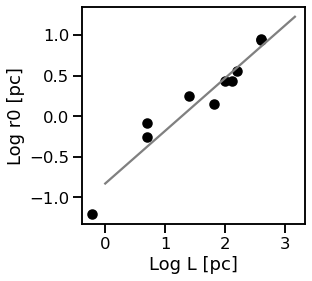

In [10]:
fig, ax=plt.subplots(figsize=(4,4))
plt.scatter(logdata['log L [pc]'],logdata['log r0 [pc]'], color='black')
ax.set(xlabel='Log L [pc]', ylabel='Log r0 [pc]')

x2=np.logspace(-3,0.5)
y2=-0.83+0.65*x2
plt.plot(x2,y2, color='gray')

In [11]:
x,y=np.array(logdata['log L [pc]']),np.array(logdata['log r0 [pc]'])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     107.1
Date:                Fri, 20 Aug 2021   Prob (F-statistic):           6.57e-06
Time:                        08:45:23   Log-Likelihood:                 4.2148
No. Observations:                  10   AIC:                            -4.430
Df Residuals:                       8   BIC:                            -3.825
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8300      0.116     -7.179      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


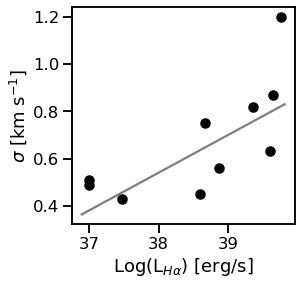

In [12]:
fig, ax=plt.subplots(figsize=(4,4))
plt.scatter(logdata['log L(H) [erg s^-1]'],logdata['log sig [km/s]'], color='black')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')

x2=np.logspace(1.567,1.6)
y2=-5.54+0.16*x2
plt.plot(x2,y2, color='gray')

In [13]:
y,x=np.array(logdata['log sig [km/s]']),np.array(logdata['log L(H) [erg s^-1]'])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     8.515
Date:                Fri, 20 Aug 2021   Prob (F-statistic):             0.0193
Time:                        08:45:23   Log-Likelihood:                 4.1459
No. Observations:                  10   AIC:                            -4.292
Df Residuals:                       8   BIC:                            -3.687
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5409      2.130     -2.602      0.0

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


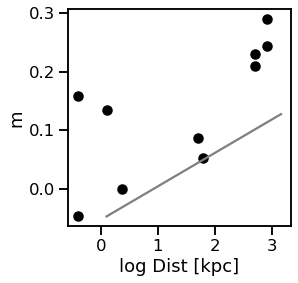

In [14]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(logdata['log Dist [kpc]'],np.log10(logdata['m']), color='black')
ax.set(xlabel = 'log Dist [kpc]', ylabel='m')

x2=np.logspace(-1,0.5)
y2=-0.053+0.057*x2
plt.plot(x2,y2, color='gray')

In [15]:
x,y =np.array(logdata['log Dist [kpc]']),np.array(np.log10(logdata['m']))
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.515
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     8.485
Date:                Fri, 20 Aug 2021   Prob (F-statistic):             0.0195
Time:                        08:45:23   Log-Likelihood:                 11.935
No. Observations:                  10   AIC:                            -19.87
Df Residuals:                       8   BIC:                            -19.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0535      0.038      1.395      0.2

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [ ]:
logdata1=logdata.drop(6, axis=0)


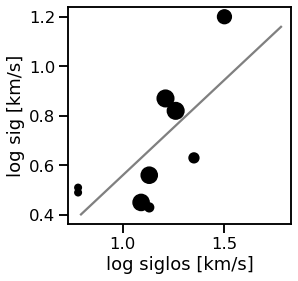

In [16]:
fig, ax = plt.subplots(figsize = (4,4))
plt.scatter(logdata1['log siglos [km/s]'],logdata1['log sig [km/s]'], color='black',s=(logdata1['log Dist [kpc]']+1.0)*70)
ax.set(xlabel = 'log siglos [km/s]', ylabel='log sig [km/s]')

x2=np.logspace(-0.1,0.25)
y2=-0.21+0.77*x2
plt.plot(x2,y2, color='gray')

plt.savefig('sigmas.pdf', bbox_inches='tight')

In [17]:
x,y =np.array(logdata1['log siglos [km/s]']),np.array(logdata1['log sig [km/s]'])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     7.601
Date:                Fri, 20 Aug 2021   Prob (F-statistic):             0.0282
Time:                        08:45:24   Log-Likelihood:                 3.3633
No. Observations:                   9   AIC:                            -2.727
Df Residuals:                       7   BIC:                            -2.332
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2152      0.324     -0.663      0.5

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [18]:
logdata1[selected_vars].corr()

,log L [pc],log L(H) [erg s^-1],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
log L [pc],1.000000,0.675259,0.922810,0.675935,0.971662,0.461813,0.580927
log L(H) [erg s^-1],0.675259,1.000000,0.715678,0.333622,0.627042,0.720315,0.893758
log Dist [kpc],0.922810,0.715678,1.000000,0.790005,0.827200,0.408709,0.502905
m,0.675935,0.333622,0.790005,1.000000,0.549874,0.108240,0.121281
log r0 [pc],0.971662,0.627042,0.827200,0.549874,1.000000,0.425745,0.558160
log sig [km/s],0.461813,0.720315,0.408709,0.108240,0.425745,1.000000,0.721516
log siglos [km/s],0.580927,0.893758,0.502905,0.121281,0.558160,0.721516,1.000000


In [19]:
logdata1

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.95,0.94,0.87,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.75,0.95,0.82,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.70,0.56,0.45,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.62,0.43,0.56,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,1.22,0.43,1.20,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.00,-0.26,0.63,1.35
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,1.36,0.25,0.43,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.90,-0.08,0.51,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.44,-1.21,0.49,0.78


## Significance tests

We can calculate the statistical significance of the correlations by using the Student t-statistic.  We test the null hypothesis that a given pair of variables is truly uncorrelated ($r = 0$) for the underlying population and that the observed $r$ for our sample of $N = 9$ sources arises solely by chance.  We want to calculate the $p$-value, which is the probability of obtaining $r$ greater than or equal to the observed value, given that there is no true correlation.  A small value of $p$ means that the null hypothesis can be rejected at a certain confidence level.  

First we calculate the t-statistic from the Pearson correlation coefficient:
$$
t = r \, \left(\frac{N - 2}{1 - r^2}\right)^{1/2}
$$
Then, we use the cumulative distribution function (CDF) of the t-distribution with $N - 1$ degrees of freedom to find the p-value. 

In [20]:
def tstatistic(r, n):
    """Compute Student t statistic for null hypothesis of no correlation
    for an observed Pearson correlation of `r` from `n` samples
    """
    return r*np.sqrt((n - 2) / (1 - r**2))

In [21]:
import scipy.stats

In [22]:
def p_from_t(t, n):
    """Compute 1-sided p-value from Student statistic `t` with `n` observations"""
    # sf is survival function: 1 - CDF
    return scipy.stats.t.sf(t, n-1)
    

In [23]:
N = 9
rvals = np.array([0.0, 0.2, 0.4, 0.5, 0.6, 0.7, 0.779, 0.8, 0.9, 0.908, 0.95, 0.981])
tvals = tstatistic(rvals, N)
pvals = p_from_t(tvals, N)
pd.DataFrame(
    {"r": rvals, "t": tvals, "p": pvals}
)

,r,t,p
0,0.000,0.000000,5.000000e-01
1,0.200,0.540062,3.019294e-01
2,0.400,1.154701,1.407685e-01
3,0.500,1.527525,8.257494e-02
4,0.600,1.984313,4.124805e-02
5,0.700,2.593355,1.597303e-02
6,0.779,3.287020,5.535582e-03
7,0.800,3.527668,3.879201e-03
8,0.900,5.462793,2.997718e-04
9,0.908,5.733922,2.184923e-04


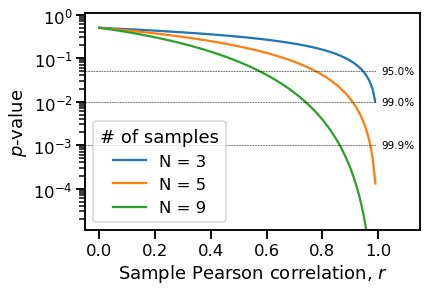

In [24]:
fig, ax = plt.subplots()
for N in 3, 5, 9:
    rvals = np.linspace(0.0, 1.0, 100, endpoint=False)
    tvals = tstatistic(rvals, N)
    pvals = p_from_t(tvals, N)
    ax.plot(rvals, pvals, label=f"N = {N}")
for p0 in 0.05, 0.01, 0.001:
    ax.axhline(p0, color="k", ls="--", lw=0.5)
    ax.text(1.07, p0, f"{100*(1-p0):.1f}%", 
            va="center", ha="center", fontsize="xx-small", 
            bbox={"color": "w"})
ax.legend(title="# of samples")
ax.set(
    xlabel="Sample Pearson correlation, $r$",
    ylabel="$p$-value",
    yscale="log",
    xlim=[-0.05, 1.15],
    ylim=[1.1e-5, 1.1],
);

I have marked confidence levels for nominal $p$-values of 0.05, 0.01, and 0.001, which are often used to judge significance.   This implies that all the correlations that we listed above are highly significant.  For instance, the correlation of $\sigma$ with luminosity, with $r=0.77$, has $p = 0.011$, so close to the 99% confidence level. 

Despite the good correlation, there is a factor of 4 difference in $\sigma$ between Carina and 30~Dor, despite similar luminosities.  **Need to check these luminostiy values**. 

In [25]:
logdata

,Region,log L(H) [erg s^-1],log SFR,log n,log L [pc],log R [pc],log Dist [kpc],m,log r0 [pc],log sig [km/s],log siglos [km/s]
0,NGC 604,39.65,-2.28,0.48,2.60,2.30,2.92,1.95,0.94,0.87,1.21
1,NGC 595,39.36,-2.59,0.60,2.60,2.30,2.92,1.75,0.95,0.82,1.26
2,Hubble X,38.60,-3.51,0.70,2.20,1.90,2.70,1.70,0.56,0.45,1.09
3,Hubble V,38.87,-3.82,0.90,2.11,1.81,2.70,1.62,0.43,0.56,1.13
4,30Dor,39.76,-1.89,2.40,2.00,1.69,1.70,1.22,0.43,1.20,1.50
5,Carina,39.60,-2.00,2.70,0.70,0.88,0.37,1.00,-0.26,0.63,1.35
6,NGC 346,38.67,-2.68,2.00,1.81,1.51,1.79,1.13,0.15,0.75,0.00
7,M8,37.47,-4.00,1.78,1.40,1.10,0.10,1.36,0.25,0.43,1.13
8,OrionL,37.00,-4.28,2.18,0.70,0.40,-0.40,0.90,-0.08,0.51,0.78
9,OrionS,37.00,-4.28,3.60,-0.22,-0.52,-0.40,1.44,-1.21,0.49,0.78


In [26]:
#logdata1=logdata.drop(4, axis=0)

r0 vs m

[Text(0, 0.5, 'Log r0 [pc]'), Text(0.5, 0, 'm [-]')]

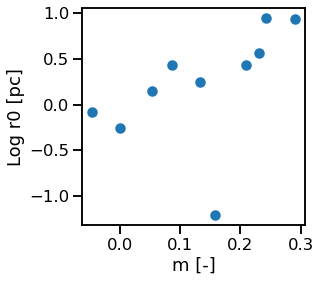

In [27]:
fig, ax=plt.subplots(figsize=(4,4))
plt.scatter(np.log10(logdata['m']),logdata['log r0 [pc]'])
ax.set(xlabel='m [-]', ylabel='Log r0 [pc]')

In [28]:
x,y=np.array(np.log10(logdata['m'])),np.array(logdata['log r0 [pc]'])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     2.727
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.137
Time:                        08:45:25   Log-Likelihood:                -7.6504
No. Observations:                  10   AIC:                             19.30
Df Residuals:                       8   BIC:                             19.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1757      0.300     -0.586      0.5

C:\Users\ZAINTEL2\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


r0 vs sig

[Text(0, 0.5, 'Log r0 [pc]'), Text(0.5, 0, '$σ$ [km s$^{-1}$]')]

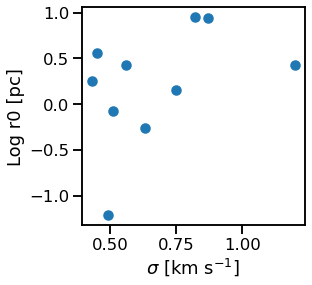

In [29]:
fig, ax=plt.subplots(figsize=(4,4))
plt.scatter(logdata['log sig [km/s]'],logdata['log r0 [pc]'])
ax.set(xlabel='$σ$ [km s$^{-1}$]', ylabel='Log r0 [pc]')

In [30]:
x,y=np.array(logdata['log sig [km/s]']),np.array(logdata['log r0 [pc]'])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     1.698
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.229
Time:                        08:45:25   Log-Likelihood:                -8.1546
No. Observations:                  10   AIC:                             20.31
Df Residuals:                       8   BIC:                             20.91
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5202      0.597     -0.871      0.4

m vs sig

[Text(0, 0.5, 'Log m [-]'), Text(0.5, 0, 'log $σ$ [km s$^{-1}$]')]

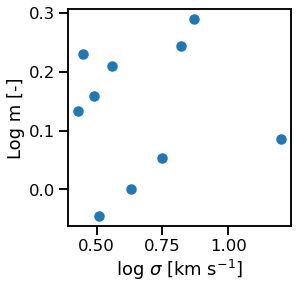

In [31]:
fig, ax=plt.subplots(figsize=(4,4))
plt.scatter(logdata['log sig [km/s]'],np.log10(logdata['m']))
ax.set(xlabel='log $σ$ [km s$^{-1}$]', ylabel='Log m [-]')

In [32]:
x,y=np.array(logdata['log sig [km/s]']),np.array(np.log10(logdata['m']))
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.120
Method:                 Least Squares   F-statistic:                   0.03580
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.855
Time:                        08:45:26   Log-Likelihood:                 8.3421
No. Observations:                  10   AIC:                            -12.68
Df Residuals:                       8   BIC:                            -12.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1153      0.115      1.005      0.3

D vs sig

[Text(0, 0.5, 'LogDiam [pc]'), Text(0.5, 0, '$σ$ [km s$^{-1}$]')]

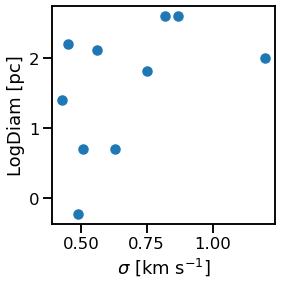

In [33]:
fig, ax=plt.subplots(figsize=(4,4))
plt.scatter(logdata['log sig [km/s]'], logdata['log L [pc]'])
ax.set(ylabel='LogDiam [pc]', xlabel='$σ$ [km s$^{-1}$]')

In [34]:
x,y=np.array(logdata['log sig [km/s]']),np.array(logdata['log L [pc]'])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     2.228
Date:                Fri, 20 Aug 2021   Prob (F-statistic):              0.174
Time:                        08:45:26   Log-Likelihood:                -11.716
No. Observations:                  10   AIC:                             27.43
Df Residuals:                       8   BIC:                             28.04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3861      0.853      0.453      0.6

In [35]:
Moiseev=pd.read_csv('DataOthers//Moiseev2015.csv')
Ostin=pd.read_csv('DataOthers//Ostin2001.csv')
Blasco=pd.read_csv('DataOthers//Blasco2013.csv')
Rozas=pd.read_csv('DataOthers//Rozas2006.csv')
Ars=pd.read_csv('DataOthers//ArsRoy1986.csv')
Wis=pd.read_csv('DataOthers//Wis2012.csv')
Gal=pd.read_csv('DataOthers//Gallagher1983.csv')

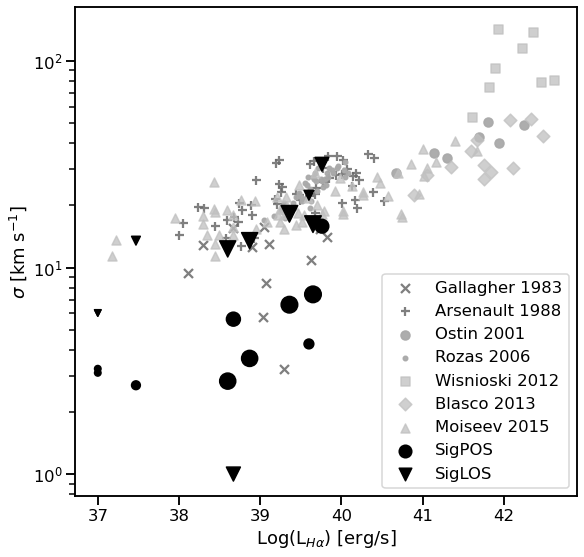

In [36]:
fig, ax=plt.subplots(figsize=(9,9))

plt.scatter(Gal.L,Gal.sig,label='Gallagher 1983',marker='x',alpha=0.85,color='dimgray')
plt.scatter(Ars.L,10**Ars.sig,label='Arsenault 1988',marker='+',alpha=0.85,color='dimgray')
plt.scatter(Ostin.L,Ostin.sig,label='Ostin 2001',marker='o',alpha=0.95,color='darkgray')
plt.scatter(Rozas.L,10**(Rozas.sig),label='Rozas 2006',marker='.',alpha=0.95,color='darkgray')
plt.scatter(Wis.L,Wis.sig,label='Wisnioski 2012',marker='s',alpha=0.75,color='silver')
plt.scatter(Blasco.L,Blasco.sig,label='Blasco 2013',marker='D',alpha=0.75,color='silver')
plt.scatter(Moiseev.L,Moiseev.sig,label='Moiseev 2015',marker='^',alpha=0.75,color='silver')

plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log sig [km/s]']),marker='o',label='SigPOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)
plt.scatter(logdata['log L(H) [erg s^-1]'],10**(logdata['log siglos [km/s]']),marker='v',label='SigLOS',color='black',s=(logdata['log Dist [kpc]']+1.0)*70)

plt.yscale('log')

ax.set(
#    ylim  = [36, 43],
#    xlim  = [1, 150],
)
#ax.set_facecolor('whitesmoke')
ax.set(xlabel='Log(L$_{Hα}$) [erg/s]', ylabel='$σ$ [km s$^{-1}$]')
plt.legend()
fig.savefig('SFplots//lvss.pdf', bbox_inches='tight')


In [37]:
logdata['log Dist [kpc]']

0    2.92
1    2.92
2    2.70
3    2.70
4    1.70
5    0.37
6    1.79
7    0.10
8   -0.40
9   -0.40
Name: log Dist [kpc], dtype: float64

In [38]:
print("--- %s seconds ---" % (time.time()-start_time))


--- 19.921474933624268 seconds ---
